In [16]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import gc

import autosklearn.metrics
from autosklearn.metrics import roc_auc
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt



In [ ]:

# Configuration
SEQUENCE_LENGTH = 30
BATCH_SIZE = 16
NORMALIZATION_RANGE = (0, 1)

TRAIN_IDS = pd.read_csv('./data/Infant Pose Data/gma_score_prediction/train.csv')
TRAIN_IDS = TRAIN_IDS['gma_id']

input_directory = "pose_estimates/gma_score_prediction_pose_estimates"  # Replace with your folder path
output_file = "processed_data.npy"  # Save processed data for reuse

# Custom Dataset Class
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32)

# Function to normalize data
def normalize(data, min_val=0, max_val=1):
    return (data - np.min(data, axis=0)) / (np.ptp(data, axis=0))

# Function to create fixed-length sequences
def create_fixed_length_sequences(data, seq_length):
    return np.array([data[i:i+seq_length] for i in range(len(data) - seq_length + 1)])

# Function to process a single file
def process_file(file_path):
    # Load CSV
    data = pd.read_csv(file_path)
    # Group by frame and extract keypoints
    grouped = data.groupby(['video_number', 'frame'])

    def process_group(group):
        frame_data = group.sort_values('part_idx')[['x', 'y']].values.flatten()
        return frame_data

    sequences = grouped.apply(process_group).values
    sequences = np.array([seq for seq in sequences])

    # Normalize the sequences
    try:
        normalized_sequences = (sequences - np.min(sequences, axis=0)) / (np.ptp(sequences, axis=0))
        return normalized_sequences
    except Exception as e:
        print(f"Error normalizing sequences: {e}")
        return None
    

# Function to process all files in a directory and save iteratively
def process_directory(directory, output_file):
    # Open the file for writing
    with open(output_file, 'w') as f:
        header_written = False  # Flag to write the header only once
        for file_name in tqdm(os.listdir(directory)):
            if file_name.endswith(".csv"):
                # check if file is in train_ids
                
                if int(file_name.split(".")[0]) not in TRAIN_IDS:
                    print(f"Skipping file: {file_name.split('.')[0]}")
                    continue

                file_path = os.path.join(directory, file_name)
                # print(f"Processing file: {file_name}")
                sequences = process_file(file_path)

                # Write sequences to the file
                try:
                    for sequence in sequences:
                        if not header_written:
                            # Write header (feature names like x1, y1, x2, y2, ...)
                            header = ','.join([f"x{i//2+1}" if i % 2 == 0 else f"y{i//2+1}" for i in range(sequence.shape[0])])
                            f.write(header + '\n')
                            header_written = True
                        f.write(','.join(map(str, sequence)) + '\n')
                except Exception as e:
                    print(f"Error writing sequences to file: {file_name.split('.')[0]}")

    print(f"Processed data saved to {output_file}")




In [5]:

def process_directory(directory, output_file):
    # Open the file for writing
    with open(output_file, 'w') as f:
        header_written = False  # Flag to write the header only once
        for file_name in tqdm(os.listdir(directory)):
            if file_name.endswith(".csv"):
                # Check if file is in TRAIN_IDS
                if int(file_name.split(".")[0]) not in TRAIN_IDS:
                    print(f"Skipping file: {file_name.split('.')[0]}")
                    continue

                file_path = os.path.join(directory, file_name)
                # Process the file
                sequences = process_file(file_path)

                # Write sequences to the file
                try:
                    for sequence in sequences:
                        if not header_written:
                            # Write header
                            header = ','.join([f"x{i//2+1}" if i % 2 == 0 else f"y{i//2+1}" for i in range(sequence.shape[0])])
                            f.write(header + '\n')
                            header_written = True
                        f.write(','.join(map(str, sequence)) + '\n')
                except Exception as e:
                    print(f"Error writing sequences to file: {file_name.split('.')[0]}")

                # Explicitly free up memory
                del sequences
                gc.collect()


In [ ]:
# Procoess all files
process_directory(input_directory, output_file)

In [ ]:
# Load processed data
data = pd.read_csv(f'./processed_data.npy')
data = data.to_numpy()

seq_len = 60
stride = 30  # Overlap between sequences

sequences = []
for i in range(0, len(data) - seq_len, stride):
    sequences.append(data[i:i+seq_len])

sequences = np.array(sequences)  # Shape: (num_sequences, seq_len, 36)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
tensor_data = torch.tensor(sequences, dtype=torch.float32)


In [2]:
# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_seq_len):
        super().__init__()
        position = torch.arange(0, max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * (-torch.log(torch.tensor(10000.0)) / embed_dim))
        pe = torch.zeros(max_seq_len, embed_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Masked Time Series Transformer
class MaskedTimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim=36, embed_dim=18, num_heads=8, num_layers=4, max_seq_len=500):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_seq_len)
        self.transformer = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            dim_feedforward=512,
            batch_first=True  # Ensures (batch, seq, embed_dim) compatibility
        )
        self.output_layer = nn.Linear(embed_dim, input_dim)

    def forward(self, x, mask=None):
        # Apply input embedding and positional encoding
        x = self.embedding(x)
        x = self.positional_encoding(x)
        # Apply transformer with source key padding mask
        x = self.transformer(x, x, src_key_padding_mask=mask)
        # Output layer to reconstruct original dimensions

        return self.output_layer(x)

In [3]:
# Define training parameters
batch_size = 32
seq_len = 60
input_dim = 36
mask_prob = 0.20  # Probability of masking each feature
epochs = 100
learning_rate = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:

# Initialize model, loss function, and optimizer
model = MaskedTimeSeriesTransformer(input_dim=input_dim, embed_dim=32, num_heads=8, num_layers=4, max_seq_len=500)
model = model.to(device)  # Move model to GPU

criterion = nn.MSELoss()  # Reconstruction loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create Dataset and DataLoader
dataset = TensorDataset(tensor_data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

losses = []

# Function to create masked inputs
def create_masked_inputs(x, mask_prob):
    """
    Masks a portion of the input for training.
    """
    mask = torch.rand(x.shape) < mask_prob  # Boolean mask for features
    x_masked = x.clone()
    x_masked[mask] = 0.0  # Replace masked values with 0
    return x_masked, mask

# Training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for batch in dataloader:
        x = batch[0].to(device)  # Extract batch data

        # Step 1: Create masked inputs and mask
        x_masked, mask = create_masked_inputs(x, mask_prob)

        # Step 2: Forward pass
        output = model(x_masked)

        # Step 3: Compute loss (only for masked positions)
        loss = criterion(output[mask], x[mask])

        # Step 4: Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Step 5: Update weights
        optimizer.step()

        # Track loss for the epoch
        epoch_loss += loss.item()

    # Print epoch loss
    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")
    # append losses to a list
    losses.append(avg_loss)
    torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")


In [ ]:
# plot the learning curve
plt.plot(losses)

In [ ]:
TEST_IDS = pd.read_csv('./data/Infant Pose Data/gma_score_prediction/test.csv')
TEST_CLASS = TEST_IDS['final_assessment_score_2']
TEST_IDS = TEST_IDS['gma_id']

# randomly select a video from the TEST_IDS 
import random
video_id = random.choice(TEST_IDS)
label = TEST_CLASS[TEST_IDS == video_id].values[0]

# Load the video data
sequences = process_file(f"pose_estimates/gma_score_prediction_pose_estimates/{video_id}.csv")

# Load pre-trained model
model = MaskedTimeSeriesTransformer(input_dim=36, embed_dim=32, num_heads=8, num_layers=4, max_seq_len=500)
model.load_state_dict(torch.load(f"./weights/latest.pth"))  # Load trained model weights
model.to(device)
model.eval()

# get all latents for all videos in the test set
latent = model.embedding(torch.tensor(sequences, dtype=torch.float32).to(device))

print(latent.shape, label)

In [6]:
TRAIN_IDS = pd.read_csv('./data/Infant Pose Data/gma_score_prediction/train.csv')
TRAIN_CLASS = TRAIN_IDS['final_assessment_score_2']


In [7]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load test metadata
TEST_IDS = pd.read_csv('./data/Infant Pose Data/gma_score_prediction/test.csv')
TEST_CLASS = TEST_IDS['final_assessment_score_2']  # Labels
TEST_IDS = TEST_IDS['gma_id']  # Video IDs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN_IDS = pd.read_csv('./data/Infant Pose Data/gma_score_prediction/train.csv')
TRAIN_CLASS = TRAIN_IDS['final_assessment_score_2']
TRAIN_IDS = TRAIN_IDS['gma_id']



# Load pre-trained model
model = MaskedTimeSeriesTransformer(input_dim=36, embed_dim=32, num_heads=8, num_layers=4, max_seq_len=500)
model.load_state_dict(torch.load(f"./weights/latest.pth"))  # Load trained model weights
model.to(device)
model.eval()

# Function to extract latent embeddings for a video
def extract_video_latents(video_id):
    """
    Process a single video and extract its latent embeddings.
    Args:
        video_id: ID of the video to process.
    Returns:
        latent_embeddings: Tensor of latent embeddings for all sequences.
    """
    # Load the video data
    sequences = process_file(f"pose_estimates/gma_score_prediction_pose_estimates/{video_id}.csv")
    sequences = torch.tensor(sequences, dtype=torch.float32).to(device)  # Convert to tensor and move to GPU/CPU as needed

    with torch.no_grad():
        # Extract latent embeddings for all sequences
        latents = []
        for seq in sequences :
            latent = model.embedding(torch.tensor(seq, dtype=torch.float32).to(device))
            latents.append(latent)
        mean_latents = torch.mean(torch.stack(latents), dim=0)

    return mean_latents

# Extract latent embeddings for all videos in the test set
all_latents = []
all_labels = []


In [ ]:

for video_id, label in zip(TRAIN_IDS, TRAIN_CLASS):
    latents = extract_video_latents(video_id)  # Get latent embeddings for this video
    all_latents.append([video_id, label, latents.cpu().numpy()])  # Store each latent embedding with label
    
latents_df = pd.DataFrame(all_latents, columns=["video_id", "label", "latents"])

# Expand the array into its own columns
array_expanded = pd.DataFrame(latents_df['latents'].tolist(), columns=[f'l{i+1}' for i in range(len(latents_df['latents'][0]))])

# Combine the expanded columns with the original dataframe
latents_df = pd.concat([latents_df.drop(columns=['latents']), array_expanded], axis=1)

# Save the dataframe to a CSV file
latents_df.to_csv('latents_train.csv', index=False)

In [ ]:
# make subplots for each of the 32 latents
fig, axs = plt.subplots(8, 4, figsize=(20, 30))
for i in range(32):
    ax = axs[i//4, i%4]
    ax.scatter(latents_df.index, latents_df[f'l{i+1}'], c=latents_df.label, cmap='viridis')
    ax.set_title(f"Latent {i+1}")
    ax.set_xlabel("Sequence Index")
    ax.set_ylabel("Latent Value")

plt.tight_layout()
plt.show()

Latents shape: (651, 32)


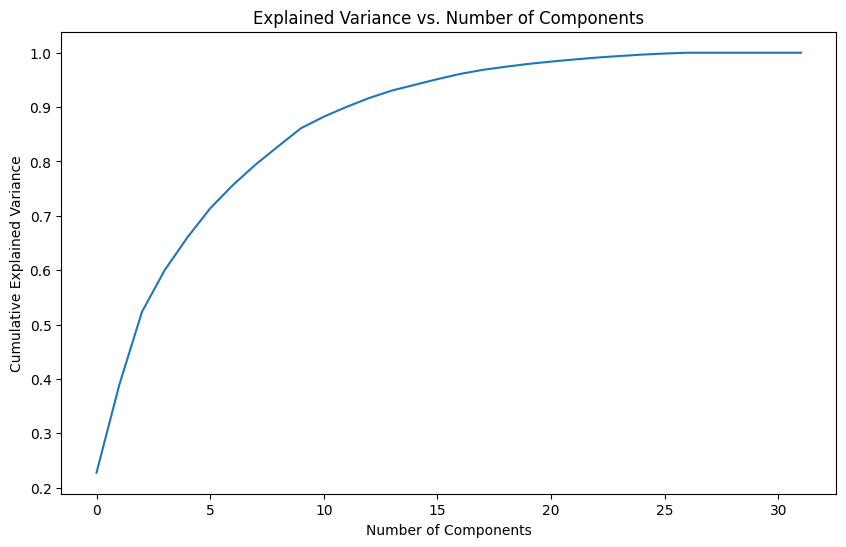

In [17]:
# run PCA on the latents and plot the explained variance
# Load the latents
latents_df = pd.read_csv('latents_train.csv')

# Extract latents
latents = latents_df.drop(columns=['video_id', 'label'])
print(f"Latents shape: {latents.shape}")

# Perform PCA

pca = PCA(n_components=32)
pca.fit(latents)

# Plot explained variance

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()

In [ ]:
# visualize a reconstruction of the data from the embeddings 
video_id =  # Choose a video ID

# Load the video data
sequences = process_file(f"pose_estimates/gma_score_prediction_pose_estimates/{video_id}.csv")

# Load pre-trained model
model = MaskedTimeSeriesTransformer(input_dim=36, embed_dim=32, num_heads=8, num_layers=4, max_seq_len=500)
model.load_state_dict(torch.load(f"model_epoch_{epoch + 1}.pth"))  # Load trained model weights
model.to(device)
model.eval()

# Extract latent embeddings for the video
latent = extract_video_latents(video_id)

# Reconstruct the video data
reconstructed = model.output_layer(latent)

# Plot the original and reconstructed sequences
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Original sequence
axs[0].plot(sequences[:, :36])
axs[0].set_title("Original Sequence")

# Reconstructed sequence
axs[1].plot(reconstructed[:, :36].cpu().detach().numpy())
axs[1].set_title("Reconstructed Sequence")

plt.tight_layout()

plt.show()

In [19]:
!pip install pandas==1.5.3

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


## RESTART THE KERNEL HERE 

In [18]:
import pandas as pd
import pickle
import sklearn
import autosklearn
from autosklearn.experimental.askl2 import AutoSklearn2Classifier
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

print(f'pandas version: {pd.__version__}')
print(f'autosklearn version: {autosklearn.__version__}')
print(f'sklearn version: {sklearn.__version__}')

learned_data = pd.read_csv("latents_train.csv")


pandas version: 2.0.3
autosklearn version: 0.15.0
sklearn version: 1.3.2


In [2]:
# Define a simple classifier

classifier = AutoSklearn2Classifier(
    time_left_for_this_task=300,
    metric=autosklearn.metrics.roc_auc,
    delete_tmp_folder_after_terminate=True,
    memory_limit=None,
)


In [4]:
# recode all the labels to 0 and 1
learned_data['label'] = learned_data['label'].apply(lambda x: 0 if x == 1 else 1)

X = pd.DataFrame(learned_data.drop(columns=['video_id', 'label']))
y = pd.DataFrame(learned_data['label'])

# Fit the classifier
classifier.fit(X, y)
pickle.dump(classifier, open('classifier.pkl', 'wb')) #must be loaded with PANDAS > 2.0

In [2]:
!pip install pandas==2.0.3

import pandas as pd
import pickle

classifier = pickle.load(open('classifier.pkl', 'rb'))

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [6]:
# Evaluate the classifier
learned_data = pd.read_csv("latents_train.csv")
test_data = pd.read_csv("latents_test.csv")

# Load the classifier
classifier = pickle.load(open('classifier.pkl', 'rb'))

# recode all the labels to 0 and 1
test_data['label'] = test_data['label'].apply(lambda x: 0 if x == 1 else 1)
accuracy = classifier.score(test_data.drop(columns=['video_id', 'label']), test_data['label'])

# get the sensitivity and specificity
y_pred = classifier.predict(test_data.drop(columns=['video_id', 'label']))
y_true = test_data['label']

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}, Specificity: {specificity}")

Sensitivity: 0.0, Specificity: 1.0


/opt/miniconda/envs/predict_gma/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(
/opt/miniconda/envs/predict_gma/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(


In [33]:
y_prob = classifier.predict_proba(test_data.drop(columns=['video_id', 'label']))[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)




Optimal Threshold: 0.4481976713776683
Sensitivity: 0.9, Specificity: 0.7228915662650602


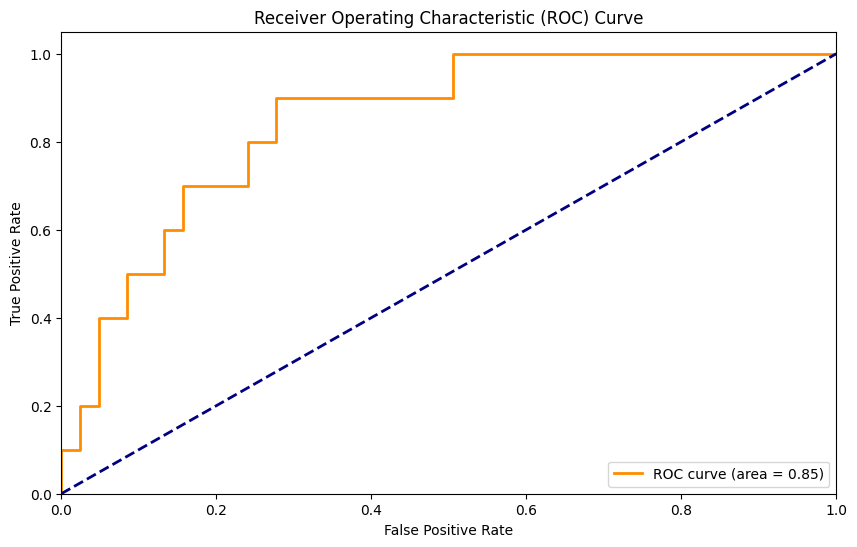

In [ ]:
# plot auc-roc curve
# Get predicted probabilities
y_pred = classifier.predict_proba(test_data.drop(columns=['video_id', 'label']))[:, 1]

# Compute ROC curve and ROC area

fpr, tpr, _ = roc_curve(test_data['label'].values, y_pred)
roc_auc = roc_auc_score(test_data['label'].values, y_pred)

# Plot ROC curve

plt.figure(figsize=(10, 6))

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('roc_curve_test.png')
plt.show()

# Choose a threshold that balances sensitivity and specificity
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

# Recompute sensitivity and specificity with the optimal threshold
y_pred = (y_prob >= optimal_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}, Specificity: {specificity}")


Text(0.5, 1.0, 'Cross Validation Scores: 0.57')

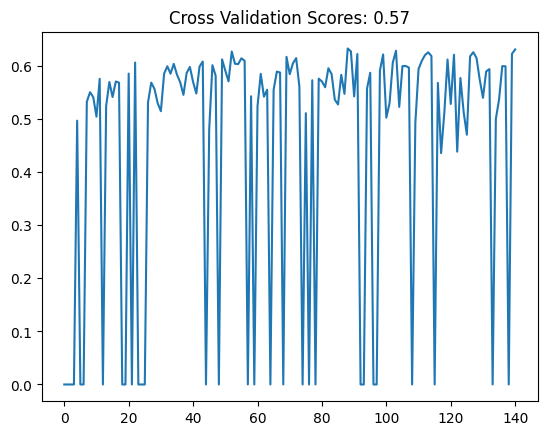

In [34]:
import numpy as np
# get cross validation scores
cv_scores = classifier.cv_results_['mean_test_score']
plt.plot(cv_scores)
plt.title(f'Cross Validation Scores: {(np.median(cv_scores)):.2f}')

In [4]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from tqdm import tqdm
import warnings
import itertools
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

learned_data = pd.read_csv("latents_train.csv")
test_data = pd.read_csv("latents_test.csv")

X_train_init = pd.DataFrame(learned_data.drop(columns=['video_id', 'label']))
y_train_init = pd.DataFrame(learned_data['label'])

y_train_init['label'] = y_train_init['label'].apply(lambda x: 0 if x == 1 else 1)

X_test = pd.DataFrame(test_data.drop(columns=['video_id', 'label']))
y_test = pd.DataFrame(test_data['label'])

y_test['label'] = y_test['label'].apply(lambda x: 0 if x == 1 else 1)

X = pd.concat([X_train_init, X_test])
y = pd.concat([y_train_init, y_test])


def make_automl_cv_m():  
    automl = AutoSklearn2Classifier(
        time_left_for_this_task=300,  # Total time for AutoML process
        metric=autosklearn.metrics.roc_auc,
        delete_tmp_folder_after_terminate=True,
        memory_limit=None
    )
    return automl

# Number of splits
n_splits = 5
rand_seeds = 42


In [5]:

skf = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=rand_seeds)

# Split using stratified K-folds
X_folds = []
y_folds = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_folds.append(X_test)  # Appending test partitions to get full coverage of the dataset in folds
    y_folds.append(y_test)

n = len(X_folds)
cv_roc_data = []


In [6]:
import sys
import logging

# Reload the logging module to restore its original state
import importlib
importlib.reload(logging)

logging.basicConfig(level=logging.INFO)


In [7]:
for i in range(n):
    automl_cv_m = make_automl_cv_m()

    X_train = pd.concat([X_folds[j] for j in range(n) if j != i])
    y_train = pd.concat([y_folds[j] for j in range(n) if j != i])

    X_test = X_folds[i]
    y_test = y_folds[i]

    automl_cv_m.fit(X_train, y_train)
    probabilities = automl_cv_m.predict_proba(X_test)[:, 1]  # Assuming class '2' is the positive class

    fpr, tpr, _ = roc_curve(y_test, probabilities, pos_label=1)
    try:
        roc_auc = roc_auc_score(y_test, probabilities)
        cv_roc_data.append((fpr, tpr, roc_auc))
    except Exception as e:
        print(f"Error computing ROC AUC: {e}")


/opt/miniconda/envs/predict_gma/lib/python3.8/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


/opt/miniconda/envs/predict_gma/lib/python3.8/site-packages/smac/intensification/parallel_scheduling.py:153: UserWarning: SuccessiveHalving is executed with 1 workers only. Consider to use pynisher to use all available workers.
  warnings.warn(
/opt/miniconda/envs/predict_gma/lib/python3.8/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():
/opt/miniconda/envs/predict_gma/lib/python3.8/site-packages/smac/intensification/parallel_scheduling.py:153: UserWarning: SuccessiveHalving is executed with 1 workers only. Consider to use pynisher to use all available workers.
  warnings.warn(
/opt/miniconda/envs/predict_gma/lib/python3.8/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():
/opt/miniconda/env

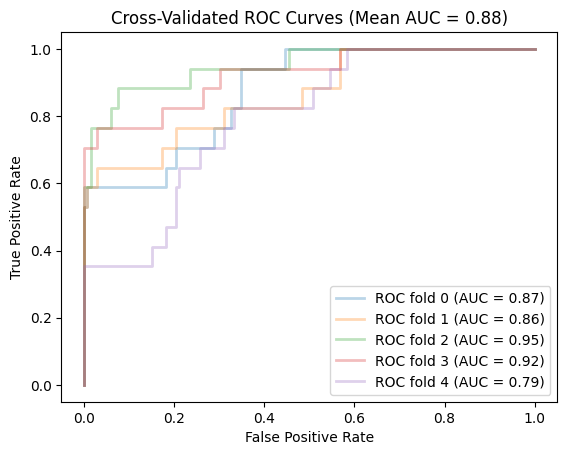

In [12]:

# Plotting all ROC curves
for i, (fpr, tpr, roc_auc) in enumerate(cv_roc_data):
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
roc_mean = np.nanmean([roc_auc for _, _, roc_auc in cv_roc_data])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cross-Validated ROC Curves (Mean AUC = {:.2f})'.format(roc_mean))
plt.legend(loc='best')
plt.savefig('roc_auc_crossvalidation.png')
plt.show()
